In [1]:
from lxml import etree
import numpy as np
import os
from skimage import io
from skimage.transform import resize
from keras.layers import Input, Dense
from keras.models import Model
import numpy as np
import pandas as pd
import tensorflow as tf
from skimage.color import rgb2gray

Using TensorFlow backend.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9242808008317177515
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1458703155
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11623534088557514886
physical_device_desc: "device: 0, name: GeForce MX150, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# parameters that you should set before running this script
filter = ['plane', 'cat'] #, 'chair', 'dog', 'bird']       # select class, this default should yield 1489 training and 1470 validation images
voc_root_folder = "../VOCdevkit/"  # please replace with the location on your laptop where you unpacked the tarball
image_size = 128    # image size that you will use for your network (input images will be resampled to this size), lower if you have troubles on your laptop (hint: use io.imshow to inspect the quality of the resampled images before feeding it into your network!)


# step1 - build list of filtered filenames
annotation_folder = os.path.join(voc_root_folder, "VOC2009/Annotations/")
annotation_files = os.listdir(annotation_folder)
filtered_filenames = []
for a_f in annotation_files:
    tree = etree.parse(os.path.join(annotation_folder, a_f))
    if np.any([tag.text == filt for tag in tree.iterfind(".//name") for filt in filter]):
        filtered_filenames.append(a_f[:-4])

# step2 - build (x,y) for TRAIN/VAL (classification)
classes_folder = os.path.join(voc_root_folder, "VOC2009/ImageSets/Main/")
classes_files = os.listdir(classes_folder)
train_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_train.txt' in c_f]
val_files = [os.path.join(classes_folder, c_f) for filt in filter for c_f in classes_files if filt in c_f and '_val.txt' in c_f]


def build_classification_dataset(list_of_files):
    """ build training or validation set

    :param list_of_files: list of filenames to build trainset with
    :return: tuple with x np.ndarray of shape (n_images, image_size, image_size, 3) and  y np.ndarray of shape (n_images, n_classes)
    """
    temp = []
    train_labels = []
    for f_cf in list_of_files:
        with open(f_cf) as file:
            lines = file.read().splitlines()
            temp.append([line.split()[0] for line in lines if int(line.split()[-1]) == 1])
            label_id = [f_ind for f_ind, filt in enumerate(filter) if filt in f_cf][0]
            train_labels.append(len(temp[-1]) * [label_id])
    train_filter = [item for l in temp for item in l]

    image_folder = os.path.join(voc_root_folder, "VOC2009/JPEGImages/")
    image_filenames = [os.path.join(image_folder, file) for f in train_filter for file in os.listdir(image_folder) if
                       f in file]
    x = np.array([resize(io.imread(img_f), (image_size, image_size, 3)) for img_f in image_filenames]).astype(
        'float32')
    # changed y to an array of shape (num_examples, num_classes) with 0 if class is not present and 1 if class is present
    y_temp = []
    for tf in train_filter:
        y_temp.append([1 if tf in l else 0 for l in temp])
    y = np.array(y_temp)

    return x, y


x_train, y_train = build_classification_dataset(train_files)
print('%i training images from %i classes' %(x_train.shape[0], y_train.shape[1]))
x_val, y_val = build_classification_dataset(val_files)
print('%i validation images from %i classes' %(x_val.shape[0],  y_train.shape[1]))

# from here, you can start building your model
# you will only need x_train and x_val for the autoencoder
# you should extend the above script for the segmentation task (you will need a slightly different function for building the label images)


467 training images from 2 classes
483 validation images from 2 classes


In [5]:
import matplotlib.pyplot as plt

n = 5  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size,3)) 
plt.show()

<Figure size 2000x400 with 5 Axes>

In [6]:
print(pd.Series(y_train[:,0]).value_counts() )
print(x_val[0].shape)
np.max(x_train[0])

0    266
1    201
dtype: int64
(128, 128, 3)


0.98818934

In [7]:
# x_train = x_train.astype('float32') / 255.
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
# x_val = x_val.astype('float32') / 255.
#x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))
# x_train.shape

In [9]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_size, image_size, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(264, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(264, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

In [10]:
from datetime import datetime
import keras
logdir="./tmp/autoencoder" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_val, x_val),
                #callbacks=[tensorboard_callback]
               )

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 20s 42ms/step - loss: 0.0564 - val_loss: 0.0344
Epoch 2/50
467/467 [==============================] - 11s 24ms/step - loss: 0.0374 - val_loss: 0.0266
Epoch 3/50
467/467 [==============================] - 11s 24ms/step - loss: 0.0270 - val_loss: 0.0209
Epoch 4/50
467/467 [==============================] - 11s 24ms/step - loss: 0.0227 - val_loss: 0.0187
Epoch 5/50
467/467 [==============================] - 11s 25ms/step - loss: 0.0203 - val_loss: 0.0192
Epoch 6/50
467/467 [==============================] - 12s 25ms/step - loss: 0.0157 - val_loss: 0.0114
Epoch 7/50
467/467 [==============================] - 11s 24ms/step - loss: 0.0159 - val_loss: 0.0176
Epoch 8/50
467/467 [==============================] - 12s 25ms/step - loss: 0.0149 - val_loss: 0.0106
Epoch 9/50
467/467 [==============================] - 11s 24ms/step - loss: 0.0153 - val_loss: 0.0118
Epoch 10/50
467/467 [===============

In [30]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D,BatchNormalization
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(image_size, image_size, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x = BatchNormalization()(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(264, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(264, (3, 3), activation='relu', padding='same')(encoded)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

from datetime import datetime
import keras
logdir="./tmp/autoencoder" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_val, x_val),
               )
 #callbacks=[tensorboard_callback]

Train on 467 samples, validate on 483 samples
Epoch 1/50
467/467 [==============================] - 15s 31ms/step - loss: 0.2368 - val_loss: 0.0765
Epoch 2/50
467/467 [==============================] - 12s 26ms/step - loss: 0.0787 - val_loss: 0.4729
Epoch 3/50
467/467 [==============================] - 12s 26ms/step - loss: 0.0491 - val_loss: 0.0509
Epoch 4/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0400 - val_loss: 0.0295
Epoch 5/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0264 - val_loss: 0.0178
Epoch 6/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0250 - val_loss: 0.0184
Epoch 7/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0212 - val_loss: 0.0171
Epoch 8/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0197 - val_loss: 0.0185
Epoch 9/50
467/467 [==============================] - 12s 27ms/step - loss: 0.0221 - val_loss: 0.0159
Epoch 10/50
467/467 [===============

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

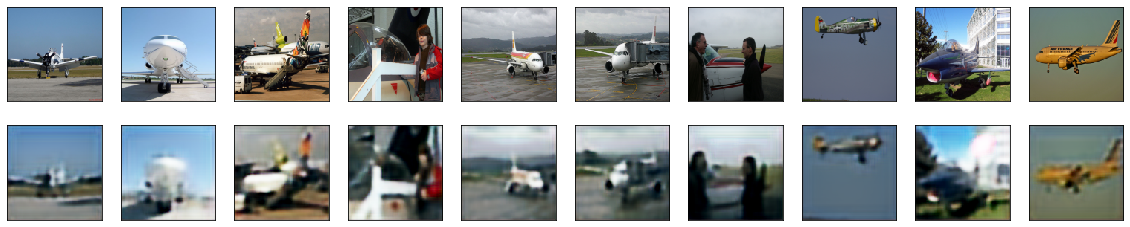

In [31]:
decoded_imgs = autoencoder.predict(x_val)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size,3)) 
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3) )
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [19]:
np.max(decoded_imgs)

0.98613113

In [17]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
input_img = Input(shape=(image_size, image_size, 3))
# Encoding network
x = Conv2D(264, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
#x = MaxPooling2D((2, 2), padding='same')(x)
#x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
#encoded = Conv2D(16, (2, 2), activation='relu', padding="same")(x)
print(encoded.shape)
# Decoding network
x = Conv2D(64, (2, 2), activation='relu', padding="same")(encoded)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)
#x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(264, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
#x = UpSampling2D((2, 2))(x)

decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
print(decoded.shape)
encoder = Model(input_img, encoded)
autoencoder_cnn = Model(input_img, decoded)
autoencoder_cnn.compile(optimizer='adadelta', loss='binary_crossentropy')

(?, 16, 16, 64)
(?, 128, 128, 3)


In [20]:
from datetime import datetime
import keras
logdir="./tmp/autoencoder" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

autoencoder_cnn.fit(x_train, x_train,
                epochs=50,
                batch_size=10,
                shuffle=True,
                validation_data=(x_val, x_val)#,
                #callbacks=[tensorboard_callback]
               )

Train on 331 samples, validate on 322 samples
Epoch 1/50
331/331 [==============================] - 19s 57ms/step - loss: 0.6549 - val_loss: 0.6056
Epoch 2/50
331/331 [==============================] - 18s 56ms/step - loss: 0.6174 - val_loss: 0.6534
Epoch 3/50
331/331 [==============================] - 19s 56ms/step - loss: 0.6079 - val_loss: 0.6049
Epoch 4/50
331/331 [==============================] - 19s 56ms/step - loss: 0.6042 - val_loss: 0.6196
Epoch 5/50
331/331 [==============================] - 19s 56ms/step - loss: 0.6007 - val_loss: 0.5841
Epoch 6/50
331/331 [==============================] - 19s 56ms/step - loss: 0.5908 - val_loss: 0.5767
Epoch 7/50
331/331 [==============================] - 19s 57ms/step - loss: 0.5914 - val_loss: 0.5978
Epoch 8/50
331/331 [==============================] - 19s 56ms/step - loss: 0.5959 - val_loss: 0.5769
Epoch 9/50
331/331 [==============================] - 19s 56ms/step - loss: 0.5885 - val_loss: 0.5774
Epoch 10/50
331/331 [===============

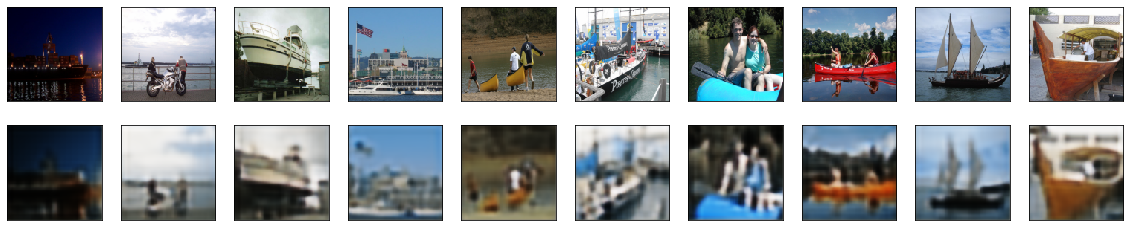

In [21]:
decoded_imgs = autoencoder_cnn.predict(x_val[:10,:,:,:])
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_val[i].reshape(image_size, image_size,3)) 
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(image_size, image_size,3) )
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [16]:
x_val.shape

(322, 128, 128, 3)

In [22]:
encoded_imgs = encoder.predict(x_val)
print(encoded_imgs.shape)
encoded_imgs = encoded_imgs.reshape((len(encoded_imgs), np.prod(encoded_imgs.shape[1:])))
print(encoded_imgs.shape)

(322, 16, 16, 64)
(322, 16384)


In [23]:
y_val2=y_val[:,0]
y_val2 #Get Labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('muted')
sns.set_context("notebook", font_scale=1.5,
                rc={"lines.linewidth": 2.5})
RS = 123


def fashion_scatter(x, colors):
    # choose a color palette with seaborn.
    num_classes = len(np.unique(colors))
    palette = np.array(sns.color_palette("hls", num_classes))

    # create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # add the labels for each digit corresponding to the label
    txts = []

    for i in range(num_classes):

        # Position of each label at median of data points.

        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)

    return f, ax, sc, txts

t-SNE done! Time elapsed: 4.4254467487335205 seconds


(<Figure size 576x576 with 1 Axes>,
 [Text(3.1080248, -0.360008, '0'), Text(-1.295604, 0.54989123, '1')])

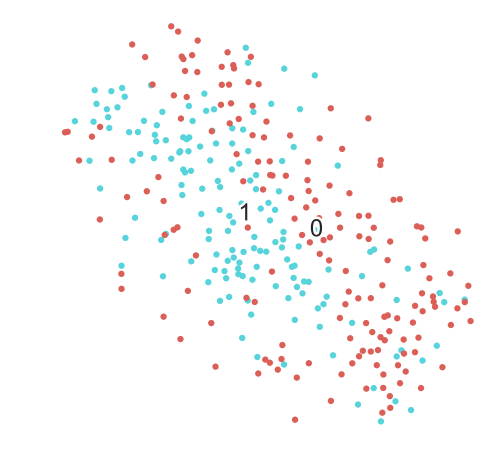

In [25]:

from sklearn.manifold import TSNE
import time
time_start = time.time()
fashion_tsne = TSNE(random_state=42).fit_transform(encoded_imgs)

print( 't-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))
fashion_scatter(fashion_tsne, y_val2)